In [1]:
%load_ext autoreload
%autoreload 2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import time

from benchmarks.models.idw import run_IDW_benchmark
from benchmarks.models.kriging import kriging_external_drift

from utils.load import *
from utils.visualisation import *
from utils.sampling import stratified_spatial_sampling_dual

/opt/miniconda3/envs/fyp/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
config = read_config('config.yaml')

In [3]:
radar_df = load_radar_dataset(folder_name='sg_radar_data')
raingauge_df = load_raingauge_dataset('rainfall_data.csv', N=0)
cml_df = load_cml_dataset('CML_data_processed_2025.nc')
print(radar_df.shape)
print(raingauge_df.shape)
print(cml_df.shape)

The size of dataset is 8334
(8334, 5)
(26096, 63)
(6991632, 27)


# IDW Interpolation with rain gauge
Interpolation was conducted with both rain gauge sampling done at 5 minute and 15 minute intervals

K-MEANS STRATIFIED SPATIAL SAMPLING
Total stations: 63
Number of clusters: 8
Random seed: 123

Split configuration:
  - Test (shared): 10%
  - Statistical train: 90%
  - ML train: 70%
  - ML validation: 20%

STEP 1: K-means Clustering
Clustering complete. Cluster centers:
  Cluster 0: (103.8761, 1.3289) - 12 stations
  Cluster 1: (103.7211, 1.3533) - 7 stations
  Cluster 2: (103.9656, 1.3530) - 9 stations
  Cluster 3: (103.6487, 1.2749) - 2 stations
  Cluster 4: (103.8192, 1.2958) - 9 stations
  Cluster 5: (103.8591, 1.3867) - 9 stations
  Cluster 6: (103.7713, 1.2871) - 8 stations
  Cluster 7: (103.7632, 1.4335) - 7 stations

STEP 2: Creating Shared Test Set (10%)
  Cluster 0: 12 stations → 1 test, 11 remaining
  Cluster 1: 7 stations → 1 test, 6 remaining
  Cluster 2: 9 stations → 1 test, 8 remaining
  Cluster 3: 2 stations → 0 test, 2 remaining
  Cluster 4: 9 stations → 1 test, 8 remaining
  Cluster 5: 9 stations → 1 test, 8 remaining
  Cluster 6: 8 stations → 1 test, 7 remaining
  

26096it [09:28, 45.91it/s]


CALCULATING LOS
26096
The average RMSE loss was 0.6974986705137588 mm/hr
The time taken was 568.5576651096344 seconds


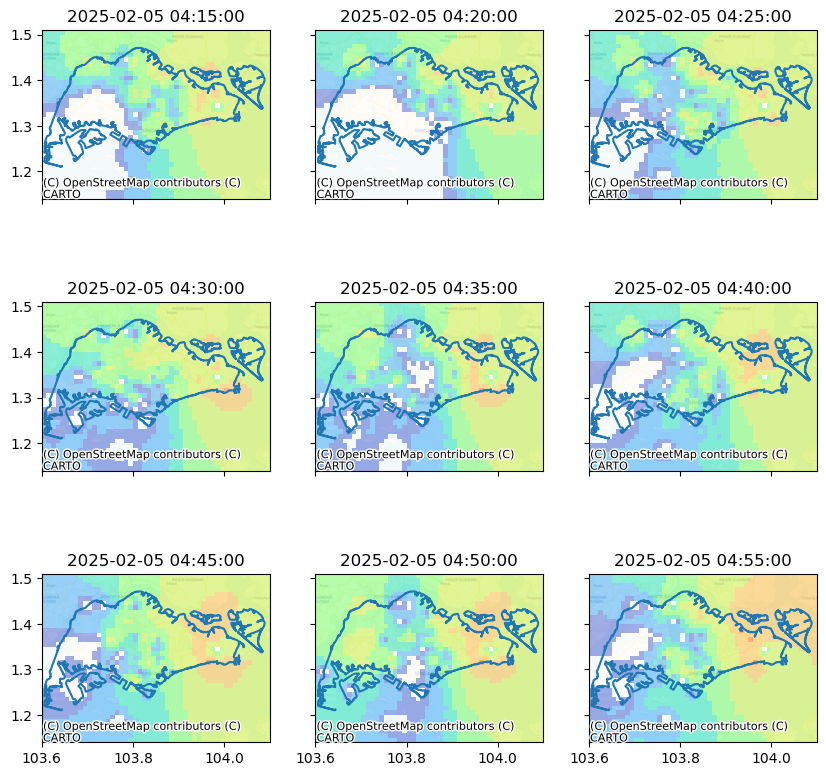

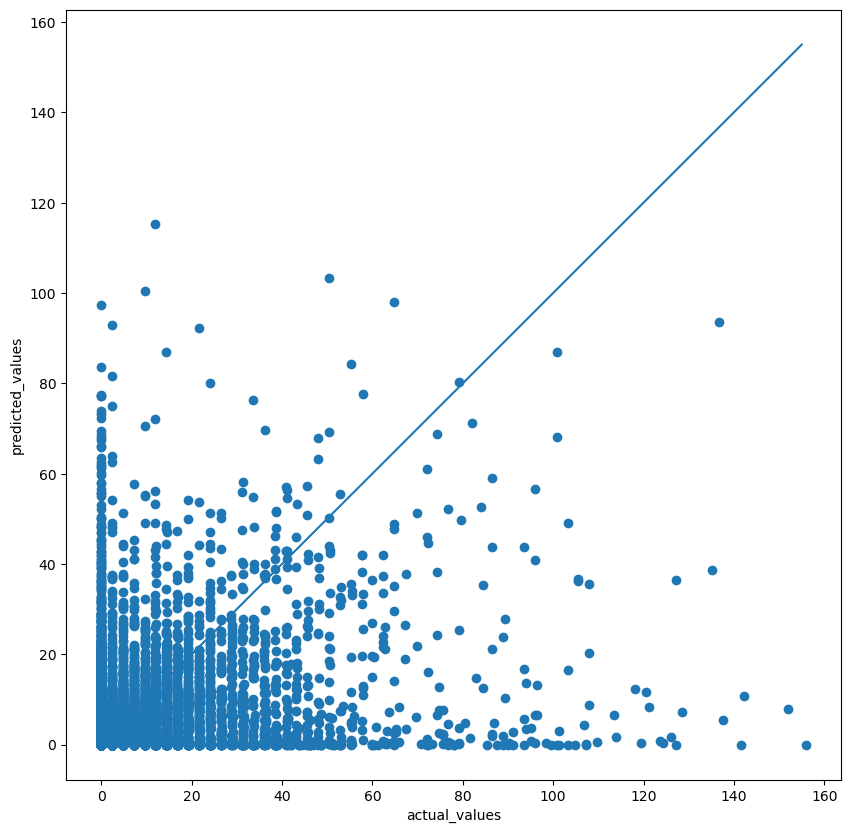

In [7]:
raingauge_df_5mins = raingauge_df.mul(12)
raingauge_df_15mins = raingauge_df.resample('15min').sum().mul(4) #resamples to 15 mins and converts to mm/hour rainfall rate
station_dict = get_gauge_coordinate_mappings()

raingauge_choice_df = raingauge_df_5mins
training_ratio = 0.7

station_list = get_station_coordinate_mappings()
station_split = stratified_spatial_sampling_dual(station_list, seed=123, plot=False)

training_stations=station_split['statistical']['train']
test_stations=station_split['statistical']['test']

gridx = np.arange(103.605, 104.1, 0.01)
gridy = np.arange(1.145, 1.51, 0.01)
gridy = gridy[::-1] #invert the y-axis to correspond with correct orientation of map output

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(10,10))

#With plotting
idw_RMSE = run_IDW_benchmark(raingauge_choice_df,
                             coordinates=station_dict,
                             training_stations=training_stations,
                             test_stations=test_stations,
                             power=2, 
                             loss_hist=False,
                             x_grid=gridx, 
                             y_grid=gridy, 
                             ax=ax,
                             axis_cols=3,
                             axis_rows=3,
                             plot_time_start=pd.Timestamp("2025-02-05 04:15:00"),
                             n_nearest=15,
                             regression_plot=True
                             )


# #Without plotting
# idw_RMSE = run_IDW_benchmark(raingauge_choice_df,
#                              coordinates=station_dict,
#                              training_stations=training_stations,
#                              validation_stations=validation_stations,
#                              power=2, 
#                              loss_hist=False,
#                              x_grid=gridx, 
#                              y_grid=gridy,
#                              n_nearest=5
#                              )
for idx, axi in enumerate(ax.flatten()):
  visualise_singapore_outline(ax = axi)

# Kriging interpolation with rain gauge

In [6]:
random.seed(111)
total_RMSE_loss = 0.0
invalid_kriges = 0
count = 0
training_ratio = config['dataset_parameters']['train_size']
station_names = []
station_dict = get_gauge_coordinate_mappings()
for key in station_dict.keys():
  station_names.append(key,)

training_stations = random.sample(station_names, int(len(station_names) * training_ratio))
validation_stations = [s for s in station_names if s not in training_stations]

loss_arr = []

start = time.time()

for i in tqdm(range(len(raingauge_choice))):
  count += 1
  df = raingauge_df_5mins.iloc[i].fillna(0)

  kriging_result, keiging_variance = kriging_external_drift(df=df, 
                                                            station_names=training_stations, 
                                                            station_dict=station_dict, 
                                                            variogram_model='exponential', 
                                                            method='ordinary')
  # print(kriging_result) #kriging_result[row][col]
  # plt.imshow(kriging_result, origin='lower')
  if kriging_result is None:
    invalid_kriges += 1
    continue

  #Calculate loss
  RSE_loss = 0.0
  station_count = 0
  for validation_station in validation_stations:
    rain_gauge_value = df[validation_station]
    lat, long = station_dict[validation_station]
    row = math.floor((lat - 1.14) / 0.01)
    col = math.floor((long - 103.6) / 0.01)
    kriged_value = kriging_result[row][col]

    error = np.sqrt((kriged_value - rain_gauge_value) ** 2)
    RSE_loss += error
    loss_arr.append(error)
    station_count += 1

  RMSE = RSE_loss / station_count

  total_RMSE_loss += RMSE
  # print(f"RMSE: {RMSE}")

end = time.time()

print(f"invalid kriges: {invalid_kriges}")
print(f"final average loss: {total_RMSE_loss / (len(raingauge_choice)-invalid_kriges)}")
print(f"final average loss (0 rain = 0 loss): {total_RMSE_loss / (len(raingauge_choice))}")
print(f"Time taken = {end - start}")

plt.figure(figsize=(15,8))
plt.hist(loss_arr, bins=30, log=True)
plt.show()


NameError: name 'raingauge_choice' is not defined

In [ ]:
print(df)